In [1]:
import numpy as np
from math import sqrt
import torch
import pandas as pd
import torch.nn.functional as F
import random
from collections import OrderedDict
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('font', **{'family': 'DejaVu Sans', 'size'   : 16})
matplotlib.rc('figure', figsize=(15, 7.5))

C:\Users\nicol\AppData\Local\Temp\ipykernel_24108\103376597.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
use_toy_problem = False  # use toy problem or real dataset
K = 32  # num latent features for U and V
train_frac = 0.7  # fraction of R to use as train vs val
num_epochs = 100
lr = 0.1  # learning rate
'''
4 models: 
    1. From-scratch linear: 'scratch-linear'
    2. Pytorch linear: 'pytorch-linear'
    3. Pytorch non-linear (simple): 'pytorch-nonlinear-simple'
    4. Pytorch non-linear (complex): 'pytorch-nonlinear-complex'
''' 
# Running multiple models will plot the performance on the same plot
model_definitions = [
    # 'scratch-linear',
    'pytorch-linear'
]  # can specify multiple models
run_all_models = False  # or can just set this to True to run all models

In [3]:
"""
Toy problem
- Underlying model: Each item has a feature of is action, is comedy, is rated R, is big-budget

Item 1: action, rated R
Item 2: action, comedy, rated R, big-budget
Item 3: comedy, big-budget
Item 4: big-budget
"""
def make_toy_data():
    R = np.array([
        [4, 4, 3, 4],  # likes action, dislikes comedy, likes big-budget
        [1, 2, 3, 2],  # likes comedy, dislikes action, dislikes R, dislikes big-budget
        [4, 4, 3, 3],  # likes R
        [4, 4, 3, 2],  # likes action, likes comedy, dislikes big-budget
        [2, 4, 5, 4],  # dislikes action, likes comedy, likes big-budget
    ], dtype=np.float32)
    return R

In [4]:
def get_dataset(use_toy_problem):
    if use_toy_problem:
        return make_toy_data()
    # ow Movie lens dataset, made smaller
    df = pd.read_csv('ratings.csv').astype(int)
    num_users = len(df.userId.unique())
    num_items = len(df.movieId.unique())
    user_df_dict = dict(zip(df.userId.unique(), list(range(num_users))))
    items_df_dict = dict(zip(df.movieId.unique(), list(range(num_items))))
    R = np.full((num_users, num_items), np.nan, dtype=np.float32)
    for indx, df_row in df.iterrows():
        R[user_df_dict[df_row.userId], items_df_dict[df_row.movieId]] = float(df_row.rating)
    # Make R smaller if you want
#     R = R[:, :610]
    return R

In [5]:
# Get/make dataset
R = get_dataset(use_toy_problem)
num_users, num_items = R.shape

In [6]:
def make_train_and_val_splits(R, num_rows, num_cols, train_frac):
    nan_full = lambda: np.full((num_rows, num_cols), np.nan)
    R_train, R_val = nan_full(), nan_full()
    did_train, did_val = False, False
    for row in range(num_rows):
        for col in range(num_cols):
            if np.random.random() < train_frac:
                R_train[row, col] = R[row, col]
                did_train = True
            else:
                R_val[row, col] = R[row, col]
                did_val = True
    assert did_train and did_val
    return R_train, R_val

In [7]:
# Make train/val splits
R_train, R_val = make_train_and_val_splits(R, num_users, num_items, train_frac)

In [8]:
def convert_tensor_to_np(t):
    if not torch.is_tensor(t):
        return t
    return t.detach().numpy()

In [9]:
class MatrixFactorizationLinearModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.is_linear = True
    
    def forward(self):
        raise NotImplementedError()
    
    def calculate_loss(self, R, R_hat):
        raise NotImplementedError()
    
    def optimize(self, loss, R, R_hat, N):
        raise NotImplementedError()
    
    @staticmethod
    def mask_out_nans(R, R_hat):
        lib = np if isinstance(R, np.ndarray) else torch
        R_mask = lib.isnan(R)
        R[R_mask] = R_hat[R_mask]
        N = (R.shape[0] * R.shape[1]) - R_mask.sum()
        return R, N

In [10]:
class MatrixFactorizationCustomLinearModel(MatrixFactorizationLinearModel):
    def __init__(self, num_users, num_items, K, lr):
        super().__init__()
        self.lr = lr
        self.U = MatrixFactorizationCustomLinearModel.xavier_uniform_array((num_users, K))
        self.V = MatrixFactorizationCustomLinearModel.xavier_uniform_array((num_items, K))
    
    @staticmethod
    def xavier_uniform_array(arr_shape):
        limit = sqrt(6. / sqrt(arr_shape[0] + arr_shape[1]))
        weights = np.random.uniform(-limit, limit, size=arr_shape)
        return weights
    
    def forward(self):
        return self.U @ self.V.T
        
    @staticmethod
    def _calc_mse(R, R_hat, N):
        return np.square(R - R_hat).sum() / R.size
    
    def calculate_loss(self, R, R_hat):
        # Mask out nans by setting to R_hat values
        R, N = MatrixFactorizationLinearModel.mask_out_nans(R, R_hat)
        # MSE and masked R
        loss = MatrixFactorizationCustomLinearModel._calc_mse(R, R_hat, N)
        return loss, loss, R, N
    
    @staticmethod
    def _calc_mse_gradient(R, R_hat, M, N):
        return (R - R_hat)@M * -2. / N
    
    def optimize(self, loss, R, R_hat, N):
        # Calc gradient of MSE for each factor matrix ie parameter
        # MSE grad
        U_grad = MatrixFactorizationCustomLinearModel._calc_mse_gradient(R, R_hat, self.V, N)
        V_grad = MatrixFactorizationCustomLinearModel._calc_mse_gradient(R.T, R_hat.T, self.U, N)
        # Update U and V based on gradient and step size
        self.U -= self.lr * U_grad
        self.V -= self.lr * V_grad

In [11]:
class MatrixFactorizationPytorchLinearModel(MatrixFactorizationLinearModel):
    def __init__(self, num_users, num_items, K, lr):
        super().__init__()
        self.U = torch.nn.Parameter(torch.zeros((num_users, K)))
        self.V = torch.nn.Parameter(torch.zeros((num_items, K)))
        torch.nn.init.xavier_uniform_(self.U)
        torch.nn.init.xavier_uniform_(self.V)

        self.MSE = torch.nn.MSELoss()
        self.optimizer = torch.optim.SGD(
            self.parameters(),
            lr=lr,
            weight_decay=0.01,
            momentum=0.9,
        )

    def forward(self):
        P = torch.cat((self.U, torch.ones((self.U.shape[0], 1))), 1)
        Q = torch.cat((self.V, torch.ones((self.V.shape[0], 1))), 1) 
        return P @ Q.T

    def calculate_loss(self, R, R_hat):
        R = torch.tensor(R, dtype=torch.float)
        select_mask = ~torch.isnan(R)
        R = torch.masked_select(R, select_mask)
        R_hat = self.forward()
        R_hat = torch.masked_select(R_hat, select_mask)
        t_loss = self.MSE(R_hat, R)
        np_loss = convert_tensor_to_np(t_loss)
        return t_loss, np_loss, R, R.size()

    def optimize(self, loss, R, R_hat, N):
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [12]:
def train_linear_model(MF_model, R_train, R_val, num_epochs):
    train_losses, val_losses = [], []
    # Training
    for curr_epoch in range(num_epochs):
        # Train
        # Reconstruct R_hat from latent factor matrices
        R_hat = MF_model.forward()
        # Calc MSE loss of this reconstruction
        # And create a nan masked R_train for future use
        train_loss, np_train_loss, R_train_masked, N = MF_model.calculate_loss(R_train.copy(), R_hat)
        # Calc grad and update
        MF_model.optimize(train_loss, R_train_masked, R_hat, N)
        train_losses.append(np_train_loss)
        
        # Eval
        with torch.no_grad():
            val_loss, np_val_loss, _, _ = MF_model.calculate_loss(R_val.copy(), R_hat)
        val_losses.append(np_val_loss)
        print(f'Epoch {curr_epoch+1} losses -> Train: {np_train_loss} - Val: {np_val_loss}')
        
    return train_losses, val_losses

In [13]:
class MatrixFactorizationPytorchNonLinearModel(torch.nn.Module):
    def __init__(self, num_users, num_items, K, lr):
        super().__init__()
        self.is_linear = False
        
        self.U_layer = torch.nn.Linear(num_users, K)
        torch.nn.init.xavier_uniform_(self.U_layer.weight)
        self.V_layer = torch.nn.Linear(num_items, K)
        torch.nn.init.xavier_uniform_(self.V_layer.weight)
        
        self.MSE = torch.nn.MSELoss()
    
    def forward(self, U_one_hots, V_one_hots):
        raise NotImplementedError()
    
    def calculate_loss(self, R, R_hat):
        t_loss = self.MSE(R, R_hat)
        np_loss = convert_tensor_to_np(t_loss)
        return t_loss, np_loss
    
    def optimize(self, loss):
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [14]:
class SimpleNonLinearModel(MatrixFactorizationPytorchNonLinearModel):
    def __init__(self, num_users, num_items, K, lr):
        super().__init__(num_users, num_items, K, lr)        
        self.fc1 = torch.nn.Linear(2 * K, K)
        self.fc2 = torch.nn.Linear(K, 1)
        
        self.optimizer = torch.optim.SGD(self.parameters(), lr=lr)
        
    def forward(self, U_one_hots, V_one_hots):
        U_latent = self.U_layer(U_one_hots)
        V_latent = self.V_layer(V_one_hots)
        x = torch.cat((U_latent, V_latent), dim=1)
        # Non-linear transform
        x = torch.sigmoid(self.fc1(x))
        R_hat = self.fc2(x)
        return R_hat

In [15]:
class ComplexNonLinearModel(MatrixFactorizationPytorchNonLinearModel):
    def __init__(self, num_users, num_items, K, lr):
        super().__init__(num_users, num_items, K, lr) 
        drop_p = 0.25
        
        self.U_dropout = torch.nn.Dropout(p=drop_p)
        self.V_dropout = torch.nn.Dropout(p=drop_p)
        
        self.fc1 = torch.nn.Linear(2 * K, K)
        self.dropout1 = torch.nn.Dropout(p=drop_p)
        self.fc2 = torch.nn.Linear(K, K // 2)
        self.dropout2 = torch.nn.Dropout(p=drop_p)
        self.fc3 = torch.nn.Linear(K // 2, 1)
        
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        
    def forward(self, U_one_hots, V_one_hots):
        U_latent = self.U_layer(U_one_hots)
        U_latent = self.U_dropout(U_latent)
        V_latent = self.V_layer(V_one_hots)
        V_latent = self.V_dropout(V_latent)
        x = torch.cat((U_latent, V_latent), dim=1)
        # Non-linear transform
        x = torch.sigmoid(self.fc1(x))
        x = self.dropout1(x)
        x = torch.sigmoid(self.fc2(x))
        x = self.dropout2(x)
        R_hat = self.fc3(x)
        return R_hat

In [16]:
def create_inputs_and_targets(R, num_users, num_items):
    def create_one_hot(length, pos):
        one_hot = np.zeros(shape=(length,), dtype=np.float32)
        one_hot[pos] = 1.
        return one_hot
    # Inputs are one hot vectors
    U_one_hots, V_one_hots = [], []
    # Targets are flattened R without nans
    R_targets = []
    for row in range(num_users):
        row_one_hot = create_one_hot(num_users, row)
        for col in range(num_items):
            value = R[row, col]
            if not np.isnan(value):
                U_one_hots.append(row_one_hot)
                V_one_hots.append(create_one_hot(num_items, col))
                R_targets.append(value)
    return torch.tensor(U_one_hots),torch.tensor(V_one_hots), torch.tensor(R_targets, dtype=torch.float32).unsqueeze(1)

In [17]:
def train_nonlinear_model(MF_model, R_train, R_val, num_users, num_items, num_epochs):
    # Dont use matrices here as there can be a lot of "white space" in a sparse ranking matrix
    U_one_hots_train, V_one_hots_train, R_targets_train = create_inputs_and_targets(R_train, num_users, num_items)
    U_one_hots_val, V_one_hots_val, R_targets_val = create_inputs_and_targets(R_val, num_users, num_items)
    
    train_losses, val_losses = [], []
    # Training
    for curr_epoch in range(num_epochs):
        # Train
        MF_model.train()  # train mode
        # Reconstruct R_hat from latent factor matrices
        R_hat_train = MF_model.forward(U_one_hots_train, V_one_hots_train)
        # Calc MSE loss of this reconstruction
        train_loss, np_train_loss = MF_model.calculate_loss(R_targets_train, R_hat_train)
        # Calc grad and update
        MF_model.optimize(train_loss)
        train_losses.append(np_train_loss)
        
        # Eval
        MF_model.eval()  # eval mode
        R_hat_val = MF_model.forward(U_one_hots_val, V_one_hots_val)
        val_loss, np_val_loss = MF_model.calculate_loss(R_targets_val, R_hat_val)
        val_losses.append(np_val_loss)
        print(f'Epoch {curr_epoch+1} losses -> Train: {np_train_loss} - Val: {np_val_loss}')
        
    return train_losses, val_losses

In [18]:
model_dict = {'scratch-linear': MatrixFactorizationCustomLinearModel, 
              'pytorch-linear': MatrixFactorizationPytorchLinearModel,
              'pytorch-nonlinear-simple': SimpleNonLinearModel, 
              'pytorch-nonlinear-complex': ComplexNonLinearModel}

In [19]:
def train_model(model_definition, performance_dict):
    model = model_dict[model_definition](num_users, num_items, K, lr)
    print(f'Training {model_definition} model...')
    if model.is_linear:
        train_losses, val_losses = train_linear_model(model, R_train, R_val, num_epochs)
    else:
        train_losses, val_losses = \
            train_nonlinear_model(model, R_train, R_val, num_users, num_items, num_epochs)
    print('...completed training\n')
    performance_dict[model_definition] = (train_losses, val_losses)

In [20]:
def train_models():
    performance_dict = OrderedDict()
    # Run all models, or only the specified models
    model_list = list(model_dict.keys()) if run_all_models else model_definitions
    for model_definition in model_list:
        train_model(model_definition, performance_dict)
    return performance_dict

In [21]:
# Make and train model(s)
performance_dict = train_models()

Training pytorch-linear model...
Epoch 1 losses -> Train: 6.7044477462768555 - Val: 6.732804775238037
Epoch 2 losses -> Train: 6.70444393157959 - Val: 6.732804775238037
Epoch 3 losses -> Train: 6.7044358253479 - Val: 6.732803821563721
Epoch 4 losses -> Train: 6.704424858093262 - Val: 6.7328033447265625
Epoch 5 losses -> Train: 6.704411029815674 - Val: 6.7328033447265625
Epoch 6 losses -> Train: 6.7043938636779785 - Val: 6.732802391052246
Epoch 7 losses -> Train: 6.704375743865967 - Val: 6.732801914215088
Epoch 8 losses -> Train: 6.704355716705322 - Val: 6.732800483703613
Epoch 9 losses -> Train: 6.704333782196045 - Val: 6.732800483703613
Epoch 10 losses -> Train: 6.704310417175293 - Val: 6.732799053192139
Epoch 11 losses -> Train: 6.704286575317383 - Val: 6.732798099517822
Epoch 12 losses -> Train: 6.704261779785156 - Val: 6.732797622680664
Epoch 13 losses -> Train: 6.70423698425293 - Val: 6.732797145843506
Epoch 14 losses -> Train: 6.70421028137207 - Val: 6.732795238494873
Epoch 15 lo

In [22]:
def plot_performance(performance_dict, save_file='performance.png'):
    fig, ax = plt.subplots()
    for model_name, (train_losses, val_losses) in list(performance_dict.items()):
        epochs = list(range(1, len(train_losses)+1))
        ax.plot(epochs, val_losses, label=model_name, linewidth=3)
    plt.xlabel('epoch')
    plt.ylabel('val loss')
    plt.xlim(0)
    # plt.ylim(0, 15)
    
    plt.xticks([1] + list(range(10, 100, 10))+[100])
    
    # plt.yticks([0, 1, 3, 5, 7, 9, 11, 13, 15])
    
    plt.legend()
    plt.grid()
    plt.title('Val Loss by Epoch of MF Models')
    fig.savefig(save_file)
    plt.show()

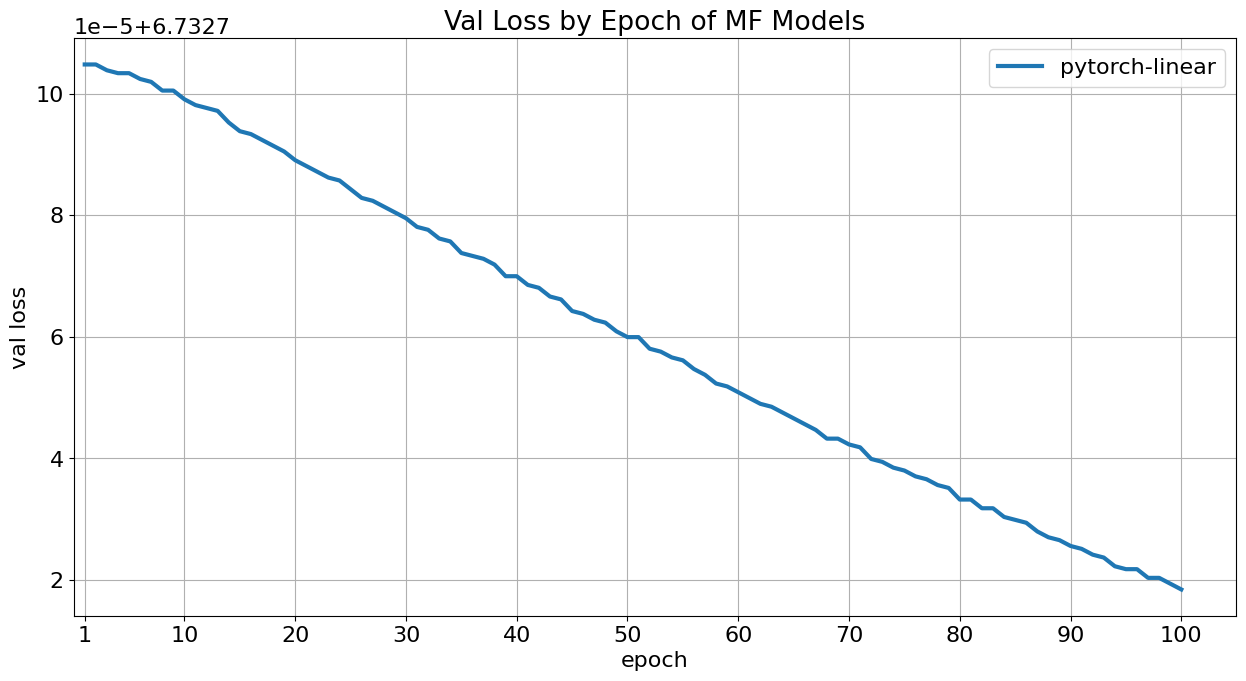

In [23]:
plot_performance(performance_dict)